In [2]:
# Import comet_ml at the top of your file
from comet_ml import Experiment

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import swifter

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.sparse import coo_matrix, hstack
import seaborn as sns

port_stem = PorterStemmer()

In [7]:
#Read dataset
train = pd.read_csv("./COVID19/Constraint_English_Train.csv").drop("id", axis=1)
Val = pd.read_csv("./COVID19/Constraint_English_Val.csv").drop("id", axis=1)

In [17]:
df = pd.concat([train, Val])

In [18]:
from sklearn.utils import shuffle

# Purify
df = df.iloc[:,[0, -1]]

# Shuffle
df = shuffle(df).reset_index(drop=True)

print(df)

                                                  tweet label
0     Our daily update is published. States reported...  real
1     About 50% of patients with #T1D + #COVID19 req...  real
2     Tanzanian club spokesman Haji S. Manara was in...  fake
3     Italian doctor couple diagnosed with coronavirus.  fake
4     Sadly today there are four people in hospital ...  real
...                                                 ...   ...
8555  Due to COVID-19 restrictions, the United Kingd...  fake
8556  FDA Urges More Coronavirus Testing so that Tre...  fake
8557  RT @PIB_India: The cases per million in the co...  real
8558  US Medical Experts Are Puzzled As To Why The U...  fake
8559  #COVID19 is primarily spread through respirato...  real

[8560 rows x 2 columns]


In [16]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english') 

def clean_text(doc):
    
    # remove punctuation
    doc = re.sub(r"[\s+\.\!\/_,|%^*#(+\"\')?<>:-]", " ", doc)
    
    # remove @
    pattern2 = r"@\S+"
    doc = re.sub(pattern2, "", doc)

    # tokenization
    tokens = nltk.word_tokenize(doc)
    
    # lower words
    tokens = [word.lower() for word in tokens]
    
    # remove stopwords
    tokens = [w for w in tokens if not w in stop_words] 
    
    # Return a cleaned string or list
    return" ".join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
#Applying lamdba function to clean text
df['tweet'] = df.swifter.apply(lambda row: clean_text(row['tweet']), axis=1)

Dask Apply:   0%|          | 0/80 [00:00<?, ?it/s]

In [27]:
MAX_FEATURES = 5000

#Assign the type of vectorizer
VECTORIZER = 'tfidf'

def fit_tfidf(documents):
    tfidf = TfidfVectorizer(input = 'content', stop_words = 'english',  
                            max_features = MAX_FEATURES )
    tfidf.fit(documents.values)
    return tfidf


# def fit_bow(documents):
#     bow = CountVectorizer(input='content', stop_words='english',
#                           max_features = MAX_FEATURES)
#     bow.fit(documents.values)
#     return bow

if VECTORIZER == 'tfidf':
    vectorizer = fit_tfidf(df['tweet'])

# elif VECTORIZER == 'bow':
#     vectorizer = fit_bow(corpus)

X = vectorizer.transform(df['tweet'])

In [36]:
y = df['label']

#Train - test
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)     

(6848, 5000)
(1712, 5000)
(6848,)
(1712,)


In [37]:
classifier = svm.SVC(kernel='linear', random_state= 0)
classifier.fit(X_train,y_train)

SVC(kernel='linear', random_state=0)

In [38]:
predict = classifier.predict(X_test)

In [39]:
print("The classification report is:")
print(classification_report(y_test, predict))

print("The accuracy for testing data is", np.mean(predict == y_test) )
print("The accuracy for training data is", np.mean(classifier.predict(X_train) == y_train) )

The classification report is:
              precision    recall  f1-score   support

        fake       0.93      0.93      0.93       849
        real       0.93      0.93      0.93       863

    accuracy                           0.93      1712
   macro avg       0.93      0.93      0.93      1712
weighted avg       0.93      0.93      0.93      1712

The accuracy for testing data is 0.9281542056074766
The accuracy for training data is 0.981892523364486


<AxesSubplot:>

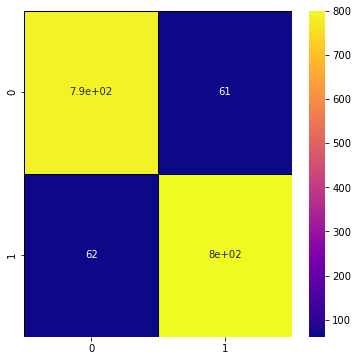

In [40]:
# Confusion Matrix of SVM
cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot = True,cmap ='plasma', linecolor ='black', linewidths = 1)